In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

In [2]:
columns = ['center','left','right','steering','throttle','reverse', 'speed']
data = pd.read_csv('./driving_log.csv', names = columns, sep=';')

In [3]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('mps')

define the dataset

In [4]:
class ImageDataset(Dataset):   
    def __init__(self, csv_file, root_dir, transform=None):
        columns = ['center','left','right','steering','throttle','reverse', 'speed']
        self.annotations = pd.read_csv('./driving_log.csv', sep=';', names = columns)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.root_dir + self.annotations.iloc[idx, 0]
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)
            
        return image

images are 320 x 160

Let's define the model

In [5]:
"""
pino = street_dataset[0]
test = nn.Conv2d(3, 3, kernel_size=5, stride=(2, 4), padding=(2,2))
nino = test(pino)
print(nino.shape)
test = nn.ConvTranspose2d(3, 3, kernel_size=5, stride=(2, 4), padding=(2,1), output_padding=1)
nino = test(nino)
nino.shape
"""

'\npino = street_dataset[0]\ntest = nn.Conv2d(3, 3, kernel_size=5, stride=(2, 4), padding=(2,2))\nnino = test(pino)\nprint(nino.shape)\ntest = nn.ConvTranspose2d(3, 3, kernel_size=5, stride=(2, 4), padding=(2,1), output_padding=1)\nnino = test(nino)\nnino.shape\n'

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=5, stride=(1, 2), padding=2),
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(8*40*40, 150)
        )
        self.bridge = nn.Sequential(nn.Linear(150, 8*40*40))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ConvTranspose2d(
                1, 1,
                kernel_size = 5,
                stride = (1, 2),
                padding=(2,2),
                output_padding=(0,1)
            ),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        x = self.encoder(x)
        x = self.bridge(x)
        x = x.reshape(x.shape[0], -1, 40, 40)
        x = self.decoder(x)

        return x


In [7]:
model = Autoencoder()

Now let's define the image preprocessing

In [8]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
])

In [9]:
street_dataset = ImageDataset('./driving_log.csv', '.', transform=img_transform)

In [10]:
for i, img in enumerate(street_dataset):
    print(i, img.size())

    if i == 3:
        break

0 torch.Size([1, 160, 320])
1 torch.Size([1, 160, 320])
2 torch.Size([1, 160, 320])
3 torch.Size([1, 160, 320])


In [11]:
train_loader = DataLoader(dataset=street_dataset, batch_size=128)

Prepare for training

In [12]:
print(device)
model.to(device)

cpu


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 2), padding=(2, 2))
    (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=12800, out_features=150, bias=True)
  )
  (bridge): Sequential(
    (0): Linear(in_features=150, out_features=12800, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ConvTranspose2d(1, 1, kernel_size=(5, 5), stride=(1, 2), padding=(2, 2), output_padding=(0, 1))
    (4): Sigm

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
num_epochs = 50
for epoch in range(num_epochs):
    for img in train_loader:
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/50], Loss: 0.0300
Epoch [6/50], Loss: 0.0264
Epoch [11/50], Loss: 0.0219
Epoch [16/50], Loss: 0.0201
Epoch [21/50], Loss: 0.0182
Epoch [26/50], Loss: 0.0177
Epoch [31/50], Loss: 0.0170
Epoch [36/50], Loss: 0.0166
Epoch [41/50], Loss: 0.0165
Epoch [46/50], Loss: 0.0158


In [15]:
"""
torch.save(model.state_dict(), 'Autoencoder.pth')
torch.save(model, './autoencoder.pt')
"""

"\ntorch.save(model.state_dict(), 'Autoencoder.pth')\ntorch.save(model, './autoencoder.pt')\n"

In [16]:
data.iloc[-2]['center']

'/IMG/center_2020_07_14_14_33_42_917.jpg'

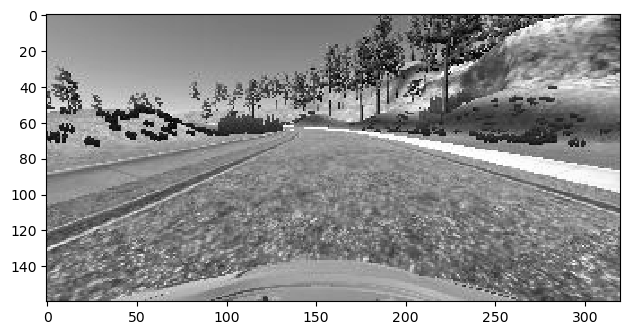

torch.Size([1, 1, 160, 320])
torch.Size([1, 160, 320])


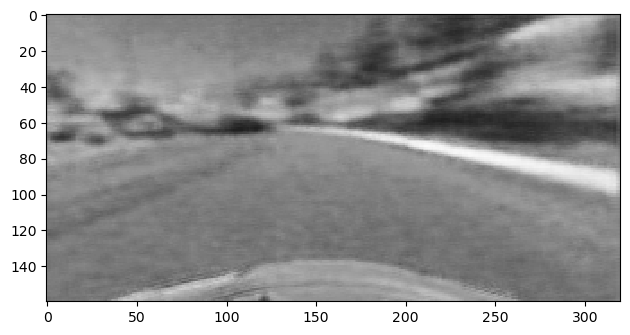

torch.Size([1, 150])


In [17]:
with torch.no_grad():
    for i in range(1):
        image = io.imread( "./" + data.iloc[-(i+1)]['center'])
        image = img_transform(image)
        io.imshow(image.cpu().numpy().transpose((1,2,0)))
        plt.show()
        image = image.to(device)
        image = image.unsqueeze(0)
        reconstruct = model(image)
        print(reconstruct.shape)
        reconstruct = reconstruct.squeeze(axis=0)
        print(reconstruct.shape)
        io.imshow(reconstruct.cpu().numpy().transpose((1,2,0)))
        plt.show()
        latent = model.encoder(image)
        print(latent.size())

In [18]:
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 2), padding=(2, 2))
    (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=12800, out_features=150, bias=True)
  )
  (bridge): Sequential(
    (0): Linear(in_features=150, out_features=12800, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ConvTranspose2d(1, 1, kernel_size=(5, 5), stride=(1, 2), padding=(2, 2), output_padding=(0, 1))
    (4): Sigm

In [19]:
"""
encodings = []
counter = 0
with torch.no_grad():
    for idx in range(len(street_dataset)):
        img = street_dataset[idx]
        img.unsqueeze(0)
        img = image.to(device)
        representation = model.encoder(img)
        representation = representation.transpose(0,1).detach().cpu().numpy()
        encodings.append(representation)
        counter = counter + 1
"""

'\nencodings = []\ncounter = 0\nwith torch.no_grad():\n    for idx in range(len(street_dataset)):\n        img = street_dataset[idx]\n        img.unsqueeze(0)\n        img = image.to(device)\n        representation = model.encoder(img)\n        representation = representation.transpose(0,1).detach().cpu().numpy()\n        encodings.append(representation)\n        counter = counter + 1\n'

In [20]:
"""enc_sq = []
for e in encodings:
    enc_sq.append(e.squeeze().tolist())"""

'enc_sq = []\nfor e in encodings:\n    enc_sq.append(e.squeeze().tolist())'

In [21]:
#tst = pd.DataFrame(enc_sq)

In [22]:
#tst.head()

In [23]:
#tst.to_csv("./encodings.csv", sep=';', index=False, header=False)